### 0. Imports

In [41]:
# from bertopic import BERTopic
#!pip install numpy==1.20
#!pip install scipy==1.6.2
from helpers import plot_across_time, plot_length, plot_metrics_scores, expand_contractions, remove_words, preprocess_quote
from helpers import generate_speaker_affiliations, save_pickle, join_quotes_with_speaker_affiliations, read_most_common, create_and_save_model_topic_clusterer
from tqdm import tqdm
from scipy.stats import ttest_ind
import os
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
sns.set


<function seaborn.rcmod.set(*args, **kwargs)>

### 1. Preprocessing
#### Getting politicians dataset
To obtain a dataset of politicians' quotations, we need to enrich the original *Quotebank* dataset with additional information about the speakers' political affiliations. To achieve that, we propose a preprocessing pipeline.

First, load the *Wikidata* table from the `.parquet` file (provided on the *Quotebank*'s Google Drive). Keep the columns containing information interesting for us - speaker's QID and label, and party's QID, discard the others and drop the rows with missing values. Convert that to a `pandas DataFrame` and dump it into a `.pickle` file. 

Then, for each of the years load the initial *Quotebank* data. The initial dataset is represented as a list of `json` objects - process it into a `DataFrame` in a line-by-line manner, only keeping the quotation content and QID, as well as the speaker's QID. Dump the dataframe into a `.pickle` file.

Next, perform an inner join between the two dataframes on the speaker QID - that way you end up with a dataframe containing quotations, along with information about the speaker's political affiliation.

The *Quotebank* dataset is divided into batches based on the quotation date - 6 files are corresponding to years from 2015 until 2020. Therefore we perform the pipeline explained above 6 times, and then merge the results into a single dataframe. We end up with a dataset of around 17m quotations.

In [2]:
from statistics import mode

# one time operation - generate a pickle file containing speaker's affiliations
PARQUET_PATH = "data/raw/speaker_attributes.parquet"
SPEAKER_AFFILIATIONS_OUT_PATH = "data/binary/speaker_attributes.pickle"

print("Generating speaker affiliations DF...")
if not os.path.exists(SPEAKER_AFFILIATIONS_OUT_PATH):
    generate_speaker_affiliations(PARQUET_PATH, SPEAKER_AFFILIATIONS_OUT_PATH)

print("Done.\n")


Generating speaker affiliations DF...
Done.



In [3]:

# dataset loading - perform for each batch of the data (2015, 2016, ..., 2019)
years = [i for i in range(2015, 2020)]
for year in years:
    DATASET_PATH_JSON_BZ2 = f"data/raw/quotes-{year}.json.bz2"
    DATASET_PATH_PICKLE = f"data/binary/data-{year}.pickle"
    MERGED_OUT_PATH = f"data/binary/data-{year}.pickle"

    print("Generating quotes DF...")
    if not os.path.exists(DATASET_PATH_PICKLE):
        save_pickle(DATASET_PATH_JSON_BZ2, DATASET_PATH_PICKLE)
    print("Done.\n")

    df_quotes = pd.read_pickle(DATASET_PATH_PICKLE)
    df_affiliations = pd.read_pickle(SPEAKER_AFFILIATIONS_OUT_PATH)

    print("Generating merged df...")
    if not os.path.exists(MERGED_OUT_PATH):
        join_quotes_with_speaker_affiliations(
            df_quotes, df_affiliations, MERGED_OUT_PATH)
    print(year, "Done.\n")


Generating quotes DF...
Done.

Generating merged df...
2015 Done.

Generating quotes DF...
Done.

Generating merged df...
2016 Done.

Generating quotes DF...
Done.

Generating merged df...
2017 Done.

Generating quotes DF...
Done.

Generating merged df...
2018 Done.

Generating quotes DF...
Done.

Generating merged df...
2019 Done.



In [4]:
# merge the results for the separate years into a single dataframe,
# and extracting date from the quote_id and saving it into a new column as datetime.
# Save all into a pickle named data.pickle

if not os.path.exists("data/binary/us-politicians.pickle"):
    years = [2015, 2016, 2017, 2018, 2019]
    paths = [f"data/binary/data-{year}.pickle" for year in years]
    dfs = [pd.read_pickle(path) for path in paths]
    merged_df = pd.concat(dfs, ignore_index=True)
    # create an additional datetime column - useful for temporal analysis
    merged_df["Date-Time"] = pd.to_datetime(merged_df['quote_id'].apply(
        lambda x: datetime.strptime(x[:10], '%Y-%m-%d')))
    merged_df.to_pickle("data/binary/us-politicians.pickle")


#### US Politicians dataset
To obtain a dataset of US Politician quotations, we proceed to:
1. Only keep the quotations where the speaker's party is `29468` (Republican party) or `29552` (Democratic party).
2. Filter out the rows that have `None` as a value in the `Candidacy` column in the Wikidata - the majority of the speakers affiliated with the political parties were not actual politicians - they are often celebrities, sports stars, TV personalities, etc. We believe it is beneficial to only take the actual politicians, as they are more likely to speak about actual political matters and represent their party's ideology.

Performing step 1 reduces the size of the dataset from 17 million rows to around 8 million rows, and step 2 reduces the size further to around 1.6 million.

In [5]:
# additional preprocessing to obtain the US politicans data
US_POLITICIANS = "data/binary/us-politicians.pickle"
DEMOCRATIC_PARTY_ID = 29552
REPUBLICAN_PARTY_ID = 29468
data = pd.read_pickle(US_POLITICIANS)
# filter to only keep the american politicians
data = data[data["party"].isin([29468, 29552])]


In [6]:
# maintain only the quotes where the speakers are actually politicians - they were candidates in at least one election
speaker_data = pd.read_parquet(PARQUET_PATH)
candidates = speaker_data[["id", "candidacy"]]
candidates = candidates.dropna()
candidates = candidates.drop(columns=["candidacy"])
candidates["id"] = candidates["id"].apply(lambda x: int(x[1:]))
candidates.head()


,id
0,23
3,207
11,815
15,946
18,1058


In [7]:
# use candidacy info to filter down the speakers.
data = pd.merge(left=data, left_on="speaker_id",
                right_on="id", right=candidates)
data = data.drop(columns=["id"])
data.head()


,speaker_id,quote_id,quotation,speaker,party,Date-Time
0,1282411,2015-06-11-000090,25-year cost estimate for the U.S. nuclear mod...,Ed Markey,29552,2015-06-11
1,1282411,2015-08-11-090504,The state is transitioning to a higher percent...,Ed Markey,29552,2015-08-11
2,1282411,2015-10-27-125840,This highly coveted TIGER grant funding would ...,Ed Markey,29552,2015-10-27
3,1282411,2015-01-19-008025,carefully cutting the Gordian knot that has ti...,Ed Markey,29552,2015-01-19
4,1282411,2015-12-09-094134,The amendments would improve the safety of agi...,Ed Markey,29552,2015-12-09


In [8]:
# save to pickle
if not os.path.exists("data/binary/us-politicians.pickle"):
    data.to_pickle("data/binary/us-politicians.pickle")


### 2. Topic clustering

In this section we'll try to divide the quotes into clusters of different topics. First, let's see which are the most common words used by politicians.

In [9]:
from nltk import download
from nltk.corpus import stopwords

# load the stopwords (extend the standard list by the contraction leftovers)
download('stopwords', quiet=True)
download('punkt', quiet=True)
stopwords = stopwords.words('english') + ['nt', 'ca', 'wo']
print("Example stopwords: ", stopwords[:10])

# load the data
data = pd.read_pickle("data/binary/us-politicians.pickle")
sample_df = data.sample(100000)

# expand contractions, remove stopwords, preprocess text
sample_df["quotation"] = sample_df["quotation"] \
    .apply(expand_contractions) \
    .apply(lambda quote: remove_words(quote, stopwords)) \
    .apply(preprocess_quote)

Example stopwords:  ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [10]:
from nltk.tokenize import word_tokenize

# look at most common word

def get_words(df):
    quotes = df["quotation"]
    tokenized = quotes.apply(lambda quote: word_tokenize(quote))
    words = tokenized.explode()
    words = words.astype("str")
    return words


words = get_words(sample_df)

print("Most common words: ")
words.value_counts()[:10]


Most common words: 


people       11531
going         8570
would         7709
think         7015
president     6110
know          6074
us            5559
get           5312
like          5292
one           5253
Name: quotation, dtype: int64

As you can see above, the most common words are somewhat meaningless for understanding the topics that politicians talk about. They are just words that appear commonly in English language. To be able to draw conclusions from the frequency analysis, we remove the 1000 most common words from the quotations and repeat the analysis.

In [11]:
# load the list of most common english words, taken from: https://gist.github.com/deekayen/4148741
def read_most_common(path):
    most_common = []
    with open(path, "r") as file:
        for line in file.readlines():
            most_common.append(line.strip())
    return most_common


most_common = read_most_common('data/misc/most_common_words_1000.txt')
most_common[:12]


['the', 'of', 'to', 'and', 'a', 'in', 'is', 'it', 'you', 'that', 'he', 'was']

We make use of stemming to perform better filtering of the words. We first apply stemming to the list of common words, and then for each token in the quotations we check if the stemmed version of the token appears in the common words list. If it does, we discard this token.

In [12]:
# convert words to their stemmed versions
from nltk.stem import PorterStemmer


def filter_words(words):
    stemmer = PorterStemmer()
    most_common_stemmed = [stemmer.stem(word) for word in most_common]
    stemmed_words = {x: stemmer.stem(x) for x in (words.unique())}

    # and filter out the words w
    filtered_words = [
        word for word in words if stemmed_words[word] not in most_common_stemmed]

    return filtered_words

filtered_words = filter_words(words)

# print most popular words after filtering
pd.Series(filtered_words).value_counts()[:20]

president    6110
trump        4443
american     2991
really       2885
america      2858
something    2028
today        1792
important    1497
security     1481
americans    1449
china        1355
public       1353
health       1328
campaign     1299
political    1283
congress     1271
democrats    1263
obama        1248
vote         1234
donald       1197
dtype: int64

The results are much more meaningful - we can see keywords typical for politcs, e.g. 'america', 'president' or 'administration'. Let's visualize the results by plotting three word clouds:
* one for all the speakers
* one for the Democratic speakers only
* one for the Republican speakers only

<Figure size 720x1440 with 0 Axes>

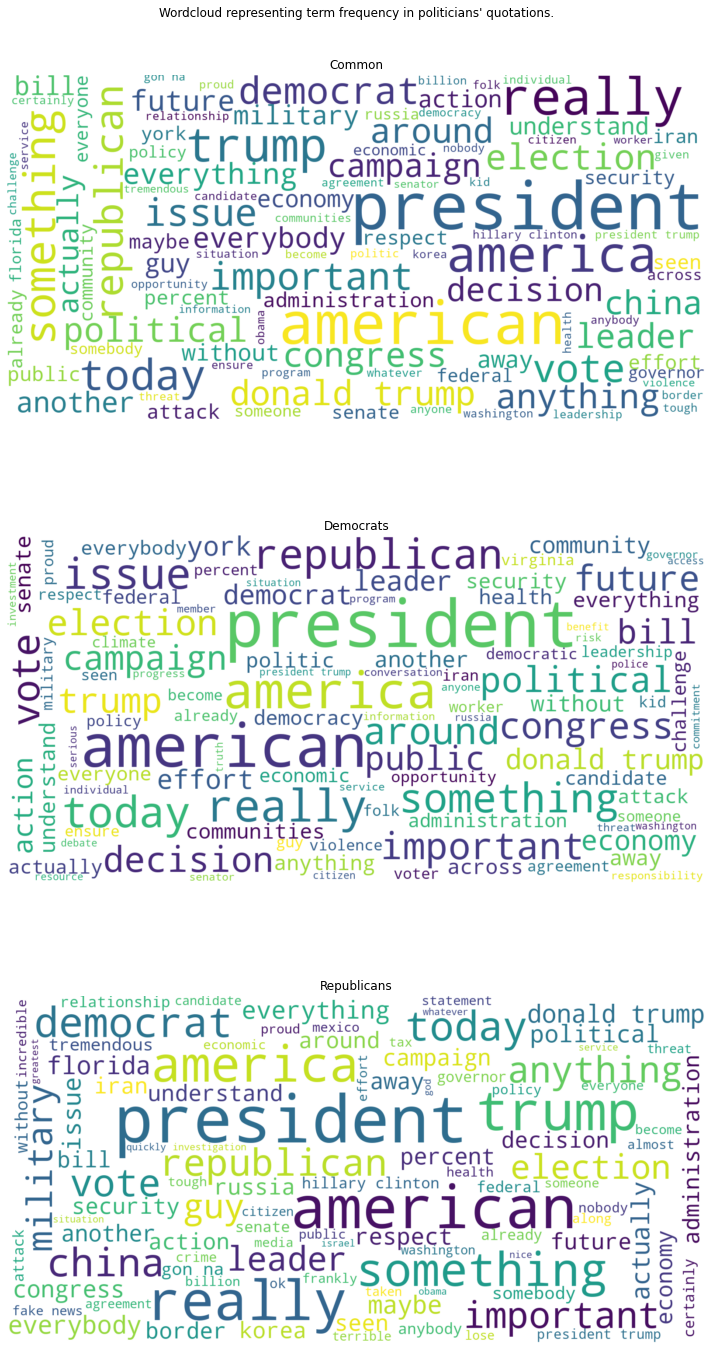

In [13]:
# adapted from: https://www.datacamp.com/community/tutorials/wordcloud-python
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def divide_by_party(df):
    democratic_party = DEMOCRATIC_PARTY_ID
    republican_party = REPUBLICAN_PARTY_ID
    democrats = df[df["party"] == democratic_party]
    republicans = df[df["party"] == republican_party]
    all_speakers = df.copy()

    return all_speakers, democrats, republicans

def make_wordcloud(df):
    words = get_words(df)
    filtered_words = filter_words(words)

    plt.rcParams["figure.figsize"] = (10, 20)

    wordcloud = WordCloud(width=1600, height=800, max_font_size=150,
                          max_words=100, background_color="white")
    wordcloud.generate(" ".join(filtered_words))
    return wordcloud


common, democrats, republicans = divide_by_party(sample_df)

common_wordcloud = make_wordcloud(common)
democrats_worldcloud = make_wordcloud(democrats)
republican_wordcloud = make_wordcloud(republicans)

plt.figure()
fig, axs = plt.subplots(3, 1)
fig.suptitle(
    "Wordcloud representing term frequency in politicians' quotations.")

axs[0].set_title('Common')
axs[0].imshow(common_wordcloud, interpolation="bilinear")

axs[1].set_title('Democrats')
axs[1].imshow(democrats_worldcloud, interpolation="bilinear")

axs[2].set_title('Republicans')
axs[2].imshow(republican_wordcloud, interpolation="bilinear")

for ax in axs:
    ax.axis('off')

fig.tight_layout()
plt.show()


Identifying the most commonly used words is a good first step to understanding what do the politicians often talk about, but the results are a bit too fine-grained to draw meaningful conclusions from them.

To overcome this issue, we want to identify the high level concepts/topics that are commonly discussed, and classify each quote to one of the topics.

To achieve that, we first tried to use a transfer-learning approach: train a classifier on the data obtained from the [Manifesto-Project dataset](https://manifestoproject.wzb.eu), which provides sentences of the two parties' manifestos over years 2012, 2016, and 2020, labeled manually by experts to one of fifteen different topics/categories. Unfortunately, the data was too different from ours and thus the resulting accuracy was not satisfying. 

We then proceeded with unsupervised clustering using Bertopic, a topic modeling technique that leverages transformers
and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the
topic descriptions. After a quick manual preprocessing of the quotes and a preprocessing pipeline from Bertopic library
itself, we trained the model with a third of the dataset (0.6 million quotes), due to RAM limitations. Using that model we
then predicted topics for the whole dataset and saved the result in a new pickle.


In [14]:
do_training= False
if do_training:
    # Create Topic Model
    quotebank_path= "../data/binary/us-politicians.pickle"
    save_model_path = "../data/misc/BERTopic_model"
    save_pickle_path = "../data/binary/us-politicians-with-clusters"
    save_topics_txt_path= "../data/misc/topics.txt"
    create_and_save_model_topic_clusterer(quotebank_path, save_model_path, save_pickle_path, save_topics_txt_path)


Below you can see most popular words for some identified topics. For example, take a look at topic **539**,
which clearly corresponds to the concept of religion, or topic **611** which contains several keywords connected
to taxation.

In [15]:
import re

# Lets examine which are the most common words for each topic:
def read_topics(path):
    topics = {}
    with open(path, "r") as file:
        next(file)
        for line in file.readlines():
            split_line = (re.sub(r'[^A-Za-z0-9\' ]+', '', line)).split(' ')
            topic_num = split_line[1]
            topic_words = []
            for i in range(len(split_line)):
                word = split_line[i]
                if word[0] == "'":
                    if word[-1] != "'":
                        word += (" " + split_line[i+1])
                    topic_words.append(word[1:-1])
            topics[topic_num] = topic_words
    return topics


topics = read_topics("data/misc/topics.txt")
for num, words in topics.items():
    print(f"Topic {num} => {words}")


Topic 509 => ['don', 'christmas', 'didn', 'rudy', 'don don', 'haven', 'collusion', 'isn', 'seven', 'november']
Topic 71 => ['putin', 'witch', 'witch hunt', 'hunt', 'vladimir putin', 'hoax', '2016', 'isis', 'hack', '2016 election']
Topic 43 => ['iran', 'nuclear', 'iranian', 'nuclear weapon', 'nuclear weapons', 'saudi', 'iran nuclear', 'arabia', 'saudi arabia', 'nuclear program']
Topic 312 => ['black', 'racist', 'racism', 'racial', 'hatred', 'hate', 'african community', 'slavery', 'discrimination', 'sexist']
Topic 341 => ['farmers', 'coal', 'swamp', 'environmental', 'agriculture', 'rural', 'farm', 'clean energy', 'fishing', 'farmer']
Topic 335 => ['florida', 'puerto', 'hurricane', 'puerto rico', 'rico', 'floridians', 'coast', 'beach', 'miami', 'island']
Topic 539 => ['religion', 'christian', 'christians', 'bible', 'pray', 'worship', 'prayer', 'religious freedom', 'religious liberty', 'grace']
Topic 214 => ['israel', 'jewish', 'jerusalem', 'palestinian', 'israeli', 'israelis', 'netanyahu'

We will now manually annotate the clusters with their corresponding labels. We also discard some of the clusters that did relate to any meaningful topic, e.g. cluster 14 which relates to numbers and dates is not interesting in this case.

In [16]:
# Let's find the most meaningful ones and assign labels to them.
meaningful_topics = []
labels = {}

meaningful_topics.append(71)
labels[71] = "RussiaGate"

meaningful_topics.append(43)
labels[43] = "Nuclear Weapons"

meaningful_topics.append(312)
labels[312] = "Racial discrimination"

meaningful_topics.append(341)
labels[341] = "Primary sector"

meaningful_topics.append(335)
labels[335] = "Hurricane"

meaningful_topics.append(539)
labels[539] = "Religion"

meaningful_topics.append(214)
labels[214] = "Israel"

meaningful_topics.append(663)
labels[663] = "United Kingdom"

meaningful_topics.append(6)
labels[6] = "North Korea"

meaningful_topics.append(496)
labels[496] = "Hillary Clinton"

meaningful_topics.append(93)
labels[93] = "Mexican Border"

meaningful_topics.append(611)
labels[611] = "Taxes"

meaningful_topics.append(471)
labels[471] = "Republican Party"

meaningful_topics.append(164)
labels[164] = "ISIS"

meaningful_topics.append(86)
labels[86] = "Guns"

meaningful_topics.append(380)
labels[380] = "Illegal immigration"

meaningful_topics.append(454)
labels[454] = "Obama"

meaningful_topics.append(529)
labels[529] = "Education"

meaningful_topics.append(69)
labels[69] = "Joe Biden"

meaningful_topics.append(484)
labels[484] = "Fake News"

meaningful_topics.append(29)
labels[29] = "European Union"

meaningful_topics.append(492)
labels[492] = "Legislation"

meaningful_topics.append(159)
labels[159] = "Terrorism"

meaningful_topics.append(343)
labels[343] = "Climate Change"

meaningful_topics.append(589)
labels[589] = "Economy"

meaningful_topics.append(620)
labels[620] = "Trade"

meaningful_topics.append(459)
labels[459] = "Democracy"

meaningful_topics.append(241)
labels[241] = "LGBTQ policies"

meaningful_topics.append(505)
labels[505] = "Senate"

meaningful_topics.append(46)
labels[46] = "India"

meaningful_topics.append(635)
labels[635] = "Traditional Values"

meaningful_topics.append(143)
labels[143] = "Middle East"

meaningful_topics.append(160)
labels[160] = "Islam"

meaningful_topics.append(392)
labels[392] = "Healthcare"

meaningful_topics.append(24)
labels[24] = "Communism"

meaningful_topics.append(373)
labels[373] = "Family"

meaningful_topics.append(251)
labels[251] = "Constitution"

meaningful_topics.append(497)
labels[497] = "Democratic Party"


Now let's assign each quotation to one cluster, and keep only the quotations that correspond to one of the meaningful topics.

In [17]:
# Lets load the dataframe and assign labels
df_quotes_topics = pd.read_pickle(
    "data/binary/us-politicians-with-clusters.pickle")
pd.set_option('display.max_colwidth', None)
df_quotes_topics.head()


,speaker_id,quote_id,quotation,speaker,party,Date-Time,cluster
0,1282411,2015-06-11-000090,25-year cost estimate for the U.S. nuclear modernization program.,Ed Markey,29552,2015-06-11,-1
1,1282411,2015-08-11-090504,"The state is transitioning to a higher percentage of life sciences job development,",Ed Markey,29552,2015-08-11,-1
2,1282411,2015-10-27-125840,"This highly coveted TIGER grant funding would enable the City of Lowell to acquire and replace or rehabilitate eight privately-owned bridges that carry vehicles and pedestrians over the City's unique 5.6-mile network of canals.... Three of these bridges are currently closed to traffic in at least one direction and many are posted with weight restrictions which prevent school buses, transit buses, fire apparatus, or commercial trucks from crossing them, resulting in significant detours.",Ed Markey,29552,2015-10-27,-1
3,1282411,2015-01-19-008025,carefully cutting the Gordian knot that has tied up our nation's broadband networks in regulatory uncertainty since the Comcast decision.,Ed Markey,29552,2015-01-19,-1
4,1282411,2015-12-09-094134,"The amendments would improve the safety of aging natural gas distribution pipelines by directing PHMSA to improve the reporting of natural gas that is lost from these pipelines, and to implement any recommendations of a Government Accountability Office analysis of best practices and barriers that may exist to repairing and replacing these pipelines,",Ed Markey,29552,2015-12-09,-1


In [18]:
df_quotes_topics = df_quotes_topics.drop(
    df_quotes_topics[~df_quotes_topics['cluster'].isin(meaningful_topics)].index)
for num, label in labels.items():
    df_quotes_topics["cluster"].replace({num: label}, inplace=True)
df_quotes_topics.head()


,speaker_id,quote_id,quotation,speaker,party,Date-Time,cluster
10,1282411,2015-07-14-019651,carefully examine the language of the proposed agreement.,Ed Markey,29552,2015-07-14,Trade
48,1282411,2015-02-10-043813,"It sounds like a Clancy novel, but when it comes to using technology like that in our highly complex cars, imagination is the only limitation.",Ed Markey,29552,2015-02-10,RussiaGate
49,1282411,2015-10-06-041174,"I think we need to have a much closer working partnership with Russia in Syria. Advertisement We have to put other grievances, history aside. We have to find a way of working together. Syria is increasingly no longer a country. It has broken apart,",Ed Markey,29552,2015-10-06,RussiaGate
59,1282411,2015-10-08-015841,Congress has failed to protect the American people from the tragic gun violence that is plaguing our nation.,Ed Markey,29552,2015-10-08,Guns
66,1282411,2015-08-12-058254,"It's obvious from the level of enthusiasm for Donald Trump, I will never actually understand how their processes work in order to determine who is the most favorably viewed among Republican primary voters,",Ed Markey,29552,2015-08-12,Republican Party


Let's also visualize the sizes of each topic in a histogram:

<Figure size 720x720 with 0 Axes>

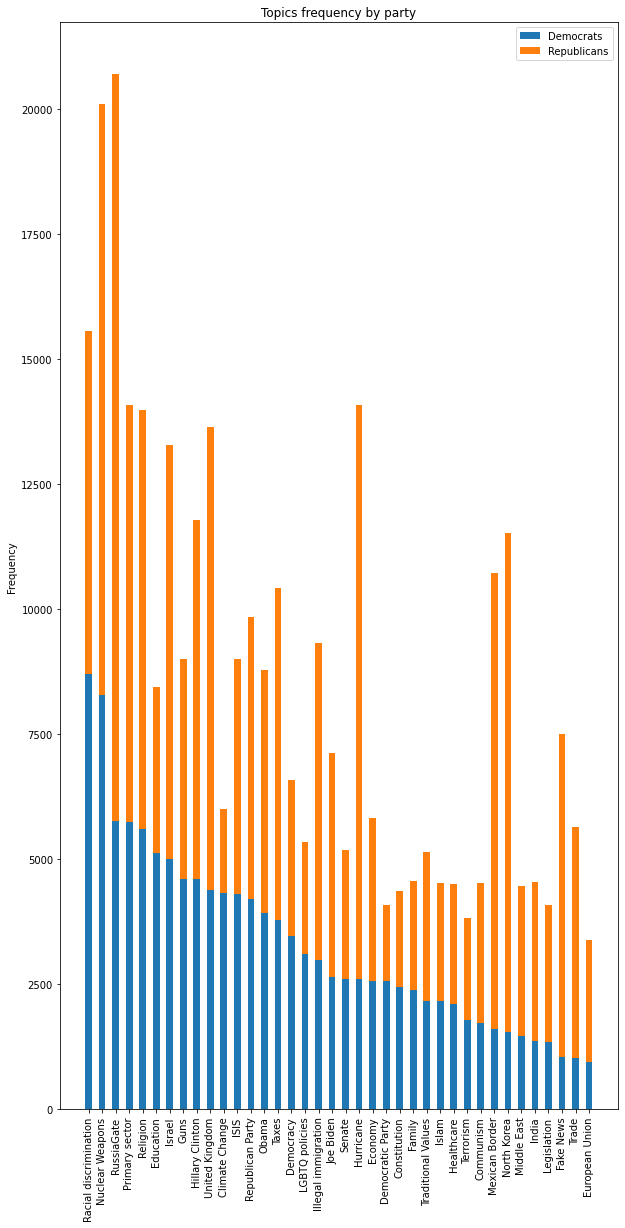

In [27]:
plt.figure(figsize=(10, 10))
categories_dem = df_quotes_topics.loc[df_quotes_topics['party']== 29552]['cluster'].value_counts().index
categories_rep = df_quotes_topics.loc[df_quotes_topics['party']== 29468]['cluster'].value_counts().index
dem_values = df_quotes_topics.loc[df_quotes_topics['party']== 29552]['cluster'].value_counts().values
rep_values = df_quotes_topics.loc[df_quotes_topics['party']== 29468]['cluster'].value_counts().values

bottom_values = np.zeros(categories_dem.size)
for i in range(categories_dem.size):
    categories_rep_list = list(categories_rep)
    categories_dem_list = list(categories_dem)
    bottom_values[categories_rep_list.index(categories_dem_list[i])] = dem_values[i]
fig, ax = plt.subplots()
ax.bar(categories_dem, dem_values, width=0.5,  label='Democrats')
ax.bar(categories_rep, rep_values, width=0.5, bottom=bottom_values, label='Republicans')

ax.set_ylabel('Frequency')
ax.set_title('Topics frequency by party')
ax.legend()
plt.xticks(rotation='vertical')
plt.show()

From the plot above we can see that the two parties have given different importance to
each topic. Let's see then what were the most popular topics of the two parties across years.

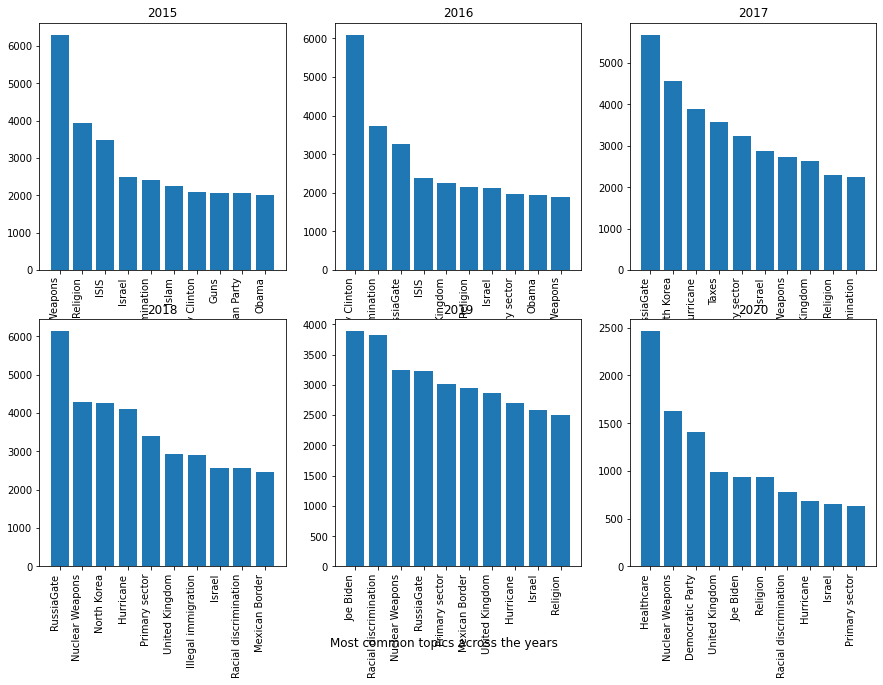

In [28]:
years = list(range(2015, 2021))

fig, axs = plt.subplots(2,3 , figsize = (15,10))
for i, ax in enumerate(axs.flat):
    mask = (df_quotes_topics['Date-Time'] <= f"{years[i]}-12-31") & (df_quotes_topics['Date-Time'] >= f"{years[i]}-01-01")
    most_common_topics = df_quotes_topics[mask]['cluster'].value_counts()[:10]
    ax.bar(list(most_common_topics.index), list(most_common_topics))
    ax.set_xticklabels(list(most_common_topics.index), rotation=90, ha='right')
    ax.set_title(years[i])

fig.supxlabel("Most common topics across the years")
plt.show()



Building a classifier based on topics

In [45]:
x = pd.get_dummies(df_quotes_topics['cluster']).to_numpy()
y = df_quotes_topics['party']
y[y == 29552] = 1
y[y == 29468] = 0
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
topic_classifier = MLPClassifier(hidden_layer_sizes = (10,10,10), activation = 'logistic', solver = 'adam').fit(X_train, y_train)
topic_classifier.score(X_test, y_test)

(325413, 38) (325413,)


0.6421781529132181

Building a classifier based on topics and years

In [47]:
x = pd.get_dummies(df_quotes_topics['cluster']).to_numpy()
year_data = df_quotes_topics['Date-Time'].apply(lambda x: x.year).to_numpy()-2015
x = np.c_[x, year_data]
y = df_quotes_topics['party']
y[y == 29552] = 1
y[y == 29468] = 0
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
topic_classifier = MLPClassifier(hidden_layer_sizes = (10,10,10), activation = 'logistic', solver = 'adam').fit(X_train, y_train)
topic_classifier.score(X_test, y_test)

0.7058407768581496

### 3. Sentiment Analysis

Having identified the topics often discussed by politicians, it is interesting to also identify their attitude towards those topics and identify whether it depends on the politicans' political affiliations.

Let's start with performing sentiment analysis: assigning a value in range $[-1, 1]$ to each quotation, where:
* $-1$ means **negative** sentiment
* $0$ means **neutral** sentiment
* $1$ means **positive** sentiment

To achieve that, we will make use of the [`VADER-Sentiment`](https://github.com/cjhutto/vaderSentiment) library - a rule-based model to approximate text sentiment. Let's see examples of sentiment approximation for 5 random quotations from Donald Trump:

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

test_sentences = data[data["speaker"] == "Donald Trump"]["quotation"].sample(5).values.tolist()

for example in test_sentences:
  res = analyzer.polarity_scores(example)
  print(f"Sentence: {example}\nSentiment: {res['compound']}\n")

Seems quite accurate. Now, let's move on to predicting sentiment for all the quotations in the dataset, and analyze the sentiment distribution (I) for all speakers together (II) for republicans and democrats separately.

In [ ]:
from tqdm import tqdm
tqdm.pandas()
data["sentiment"] = data["quotation"].progress_apply(lambda x: analyzer.polarity_scores(x)["compound"])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def vertical_subplots(columns, config, subplots=True):
    colours = ["#000000","#004949","#009292","#ff6db6","#ffb6db","#490092","#006ddb","#b66dff","#6db6ff","#b6dbff","#920000","#924900","#db6d00","#24ff24","#ffff6d"]
    means = [data.mean() for data in columns]
    stds = [data.std() for data in columns]

    if subplots:
        fig, axs = plt.subplots(len(columns), 1, sharey = True)
        subtitles = config["subtitles"]
        for ax, data, mean, std, color, subtitle in zip(axs, columns, means, stds, colours, subtitles):
            ax.hist(data.values, color = color, bins=25, density=True)
            ax.axvline(mean - std, linestyle = '--', color = "red", label = f"-std: {np.round(mean - std, 3)}")
            ax.axvline(mean + std, linestyle = '--', color = "red", label = f"+std: {np.round(mean + std, 3)}")
            ax.axvline(mean, color = 'red', lw = 3, label = f"mean: {np.round(mean, 3)}")
            ax.set_title(subtitle)
            ax.legend()

        fig.supxlabel(config["xlabel"])
        fig.supylabel(config["ylabel"])
        fig.suptitle(config["title"])
        fig.set_size_inches(10, 10)
        fig.tight_layout()
        fig.show()
    
    else:
        for data, mean, color, subtitle in zip(columns, means, stds, colours):
            plt.hist(data, label=subtitle, color=color, bins=25, density=True)
            plt.axvline(mean, color = color, lw = 3, label = f"{subtitle} mean: {np.round(mean, 3)}")
        plt.xlabel(config["xlabel"])
        plt.xlabel(config["ylabel"])
        plt.title(config["title"])
        plt.tight_layout()
        plt.show()

config = {
    "xlabel": "Sentiment value",
    "ylabel": "Density",
    "title": "Sentiment value distribution",
    "subtitles": ["All speakers", "Democratic speakers", "Republican speakers"]
}

all_speakers, democrats, republicans = divide_by_party(data)
columns = [all_speakers["sentiment"], democrats["sentiment"], republicans["sentiment"]]
vertical_subplots(columns, config)


We can see that the distributions are quite similar: in both cases most of the quotations have no strong sentiment, causing a significant peak around zero. However, the results not totally identical for both parties: on average the Democrats' quotations have a slightly more positive sentiment than those of the Republicans. Let's see if it is statistically significant:

In [ ]:
from scipy.stats import ttest_ind
ttest_ind(democrats['sentiment'], republicans['sentiment'])

The test confirms that there is a statistically significant difference between the sentiment distributions for the two parties. To make it more visible, let's look at the plots again, now plotting them both on one graph and excluding the zero-sentiment values:

In [ ]:
# now without the zero sentiment
groups = [all_speakers, democrats, republicans]
democrats_nonzero = [democrats_nonzero[democrats_nonzero["sentiment"] != 0] for group in groups]
columns_nonzero = [group["sentiment"] for group in groups_nonzero]
vertical_subplots(columns_nonzero, config)

### 4. Readability and Understandabilty Analysis

Here we conduct a readability analysis on our dataset of quotes. We load the data and use the following measures of readability to create new columns:
- Flesch reading ease: in the Flesch reading-ease test, higher scores indicate material that is easier to read;
lower numbers mark passages that are more difficult to read.
- Dale Chall readability score: different from other tests, since it uses a lookup table of the most commonly used 3000 English words. It returns the grade level necessary to understand the sentence. Hence, the higher the score, the higher is the difficulty.
- Text Standard: based upon a combination of all the library's tests, returns the estimated school grade level required to understand the text.
- Reading time: returns the reading time of the given text. Assumes 14.69ms per character.

In [ ]:
# load pickle
PICKLE_PATH = "data/binary/us-politicians.pickle"

data = pd.read_pickle(PICKLE_PATH)
data.head()


In [ ]:
import textstat as ts

# we use the textstat library to calculate the scores for each quotation
if not os.path.exists("data/binary/us-politicians-complexity.pickle"):
    data['flesch_reading_ease'] = data['quotation'].apply(
        lambda x: ts.flesch_reading_ease(x))

    data['dale_chall_readability_score'] = data['quotation'].apply(
        lambda x: ts.dale_chall_readability_score_v2(x))

    data['text_standard'] = data['quotation'].apply(
        lambda x: ts.text_standard(x, True))

    data['reading_time'] = data['quotation'].apply(
        lambda x: ts.reading_time(x))
    # save to pickle
    data.to_pickle("data/binary/us-politicians-complexity.pickle")
else:
    PICKLE_PATH = "data/binary/us-politicians-complexity.pickle"
    data = pd.read_pickle(PICKLE_PATH)

readability_features = ['flesch_reading_ease',
                        'dale_chall_readability_score', 'text_standard', 'reading_time']

data.head()


We then split the DataFrame into two, one for Democrats and one for Republicans.  We take a random sample of Republicans
quotes, since they are significantly more  than Democrats' quotes, in order to have the same amount of sentences analyzed.
This way the representations are clearer but the result doesn't change.

In [ ]:
# To have a clearer visualization we take into consideration the same amount of quotations from both parties
democrats = data[data["party"] == 29552]
republicans = data[data["party"] == 29468].sample(
    democrats['quote_id'].count())


Let's examine if our sample from the two parties is balanced across time. To do so, let's plot the distribution of the number of quotes per party across time:

In [ ]:
plot_across_time(democrats[["Date-Time", "quote_id"]].rename(columns={
                 'quote_id': 'count'}), republicans[["Date-Time", "quote_id"]].rename(columns={'quote_id': 'count'}))


We can see that, despite a few low values in 2016, the distribution is rather uniform, and the difference between the number of quotes of democrats and republicans across the year is not substantial enough to hinder our future analysis. Now let's analyse the difference in the distribution of quotes' length of the two parties:

We also plot the difference between the length of quotes, to ensure a similar distribution, as the metrics we calculated are influenced by it.

In [ ]:
plot_length(democrats, republicans)


We see that the number of quotes decreases at a similar rate for both parties as the length of quotes increases, with a few outliers over the length 3000. Let's try removing them.

In [ ]:
plot_length(democrats[democrats["quotation"].str.len() < 3000],
            republicans[republicans["quotation"].str.len() < 3000])


We can now plot the different metric scores across all speakers, from the two parties.

In [ ]:
plot_metrics_scores(democrats, republicans,
                    "Democrats vs Republicans - quotation complexity")


Let us check if there is a statistically significant difference in the values for the various metrics - 

In [ ]:
for ft in readability_features:
    res = ttest_ind(democrats[ft], republicans[ft])
    print(f"{ft:<30} : {res}")


The p-values are lower than the 0.05 threshold, i.e. the metrics do not have the same expected value for each party. Therefore there are statistically significant differences.

We see that the democratic quotations on average have a higher grade score required for reading and understading the text on each of the four metrics. These features can therefore help us predict the party affilition of a politician given their quote.  

For some futher analysis, let us plot the metrics for the two most popular speakers from each party.
And also see if there are any variations over the years.

In [ ]:
print(
    f"Most common Democratic speaker : {democrats['speaker'].value_counts()[:1]}")

print(
    f"Most common Republican speaker : {republicans['speaker'].value_counts()[:1]}")


In [ ]:
barack_obama = democrats[democrats['speaker'] == 'Barack Obama']
donald_trump = republicans[republicans['speaker'] == 'Donald Trump']

# again we take a random sample of equal number of quotes, for clearer visualizations
donald_trump = donald_trump.sample(barack_obama['quote_id'].count())

plot_metrics_scores(barack_obama, donald_trump,
                    "Barack Obama vs Donald Trump 's quotation complexity")

# and we check for statistical significance in the differece bw metric values
for ft in readability_features:
    res = ttest_ind(barack_obama[ft], donald_trump[ft])
    print(f"{ft:<30} : {res}")


The quotations of Barack Obama and Donald Trump show similar statistical differences in readability compared to their party's average. i.e The quotes from Democratic speakers on avg. require a higher grade for understandability.

We can also compare the difference in these metrics over the years.

In [ ]:
years = list(range(2015, 2021))

yearly_readability_data = {}
for ft in readability_features:
    yearly_readability_data[ft+'_rep'] = []
    yearly_readability_data[ft+'_dem'] = []

for year in years:
    year_df_rep = republicans[republicans['Date-Time'] <= f"{year}-1-31"]
    year_df_rep = year_df_rep[year_df_rep['Date-Time'] >= f"{year}-1-1"]

    year_df_dem = democrats[democrats['Date-Time'] <= f"{year}-1-31"]
    year_df_dem = year_df_dem[year_df_dem['Date-Time'] >= f"{year}-1-1"]

    for ft in readability_features:
        yearly_readability_data[ft+'_rep'].append(year_df_rep[ft].mean())
        yearly_readability_data[ft+'_dem'].append(year_df_dem[ft].mean())


x = np.arange(len(years))
width = 0.1

fig, ax = plt.subplots()
for i, (ft, score) in enumerate(yearly_readability_data.items()):
    if i < (len(yearly_readability_data.keys()) / 2):
        x_loc = x - (width/2) - (i * width)
    else:
        i = i - len(yearly_readability_data.keys()) / 2
        x_loc = x + (width/2) + (i * width)

    ax.bar(x_loc, score, width, label=ft)

ax.set_ylabel('Scores')
ax.set_title(
    'Values of readability metrics over the years, for quotes by Dem vs Rep')
ax.set_xticks(x)
ax.set_xticklabels(years)
ax.legend()

fig.tight_layout()

plt.show()


As seen in the graph above, the differences in scores for the readability metrics do not change significantly over the years.

This was a simple and mostly superficial analysis of the readability metrics for quotes by speakers of both parties, however we already discovered statistically significant differences in the scores for these metrics between the two parties. And these differences are consistent between all four metrics we judged. i.e. Quotes from republican speakers have shown to be easier to understand and require a lower grade level.

These scores could thus be useful features for our affiliation predicting classifier.

### 5. Political Classifier

In [ ]:
features = readability_features  # + sentiment score + ...

# create table that includes all features and party affiliation


def divide(df, x_cols=features, y_cols=['party']):
    return df[x_cols].to_numpy(), df[y_cols].to_numpy()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

# divide dataset into featues and label
x, y = divide(data)

# Splitting into train and test set
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=666)

# Training the model
boost_reg = GradientBoostingRegressor().fit(x_train, y_train.squeeze())

# Generating predictions
predictions = boost_reg.predict(x_test)

# Calculating r2 score
r2 = r2_score(y_test, predictions)

print("The R^2 score is {r}".format(r=np.round(r2, 4)))
